In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pickle
import json
import yfinance as yf
from run_model import train_model
import tqdm
from tqdm import tqdm

from tensorflow.keras.models import model_from_json
from lstnet_util import GetArguments, LSTNetInit
from lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile

custom_objects = {"PreSkipTrans": PreSkipTrans,
                  "PostSkipTrans": PostSkipTrans,
                  "PreARTrans": PreARTrans,
                  "PostARTrans": PostARTrans,
                  }

def multi_train(forecast_steps=1):
    for step in tqdm(range(forecast_steps)):
        train_model(horizon=step, save_name=f"large_portfolio_{step}")
    
def load_multiple_models(n_models=1):
    models=[]
    for step in tqdm(range(n_models)):
        json_file = open(f'save\large_portfolio_{step}.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json, custom_objects=custom_objects)
        loaded_model.load_weights(f"save\large_portfolio_{step}.h5")
        models.append(loaded_model)
    return models

def lstnet_forecast(models, forecast_steps, series, time_steps):
    forecast_steps=forecast_steps
    last_batch=series[-time_steps:,:]
    forecast=[]
    for step in tqdm(range(forecast_steps)):
        pred=models[step].predict(np.array(last_batch, dtype='float32').reshape(1,time_steps,series.shape[1]))
        forecast.append(pred)
    forecast=np.array(forecast)
    
    return forecast



In [11]:
tf.__version__

'2.9.1'

In [12]:
multi_train()
models=load_multiple_models()
lstnet_forecast()

100%|██████████| 1/1 [00:53<00:00, 53.12s/it]


Error: 2023-07-11 22:54:09.477285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-07-11 22:54:09.477560: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-11 22:54:16.896752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2023-07-11 22:54:16.897409: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-11 22:54:16.903536: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Ved
2023-07-11 22:54:16.904067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Ved
2023-07-11 22:54:16.904626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with o

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


TypeError: lstnet_forecast() missing 4 required positional arguments: 'models', 'forecast_steps', 'series', and 'time_steps'

UsageError: Environment does not have key: all


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pickle
import json
from tensorflow.keras.models import model_from_json
from lstnet_util import GetArguments, LSTNetInit
from lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile

In [53]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'JPM', 'V', 'JNJ', 'PG', 'XOM', 'T', 'BAC', 'WMT', 'INTC', 'PFE',
           'VZ', 'KO', 'TSLA', 'MRK', 'DIS', 'UNH', 'HD', 'ADBE', 'CMCSA', 'PEP', 'CSCO', 'NVDA', 'NFLX',
           'ABT', 'NKE', 'CVX', 'ACN', 'TMUS', 'BMY', 'LLY', 'TMO', 'IBM', 'MCD', 'ORCL', 'UPS', 'MDT', 'COST',
           'PM', 'AVGO', 'SAP', 'HON', 'NEE', 'TXN', 'MO']

data = yf.download(tickers, period="3000d",group_by='ticker', auto_adjust=True)

open_prices = pd.DataFrame({ticker: data[ticker]['Open'] for ticker in tickers})
open_prices


[*********************100%***********************]  48 of 48 completed


,AAPL,GOOGL,AMZN,MSFT,JPM,V,JNJ,PG,XOM,T,...,UPS,MDT,COST,PM,AVGO,SAP,HON,NEE,TXN,MO
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-28,11.887663,15.144895,11.163500,21.483003,29.230316,20.226016,46.367230,43.934188,50.712820,9.452125,...,48.963136,27.384566,58.850863,40.577710,24.854053,50.742418,39.685701,10.100843,22.238289,13.053400
2011-07-29,11.766848,15.120871,11.064500,21.664073,28.907055,19.700453,46.018911,43.594941,50.123438,9.155266,...,47.868238,27.338771,58.182673,40.470468,24.656037,49.873980,38.541076,10.052447,21.857138,13.113510
2011-08-01,12.074652,15.295796,11.250000,21.656197,29.567958,19.966671,46.402763,43.934198,50.142044,9.493181,...,48.719050,27.750917,59.549031,40.425315,24.934717,51.269966,39.885096,9.957444,21.974411,13.288820
2011-08-02,12.070707,15.165165,11.016000,21.238969,28.806485,19.507667,45.571097,43.206198,48.950834,9.303695,...,46.850064,26.400003,58.032543,39.747979,24.091341,48.745831,38.858616,9.878570,21.571277,13.028349
2011-08-03,11.868233,14.871622,10.648500,21.120895,28.562243,19.399807,45.045091,42.944688,48.355231,9.218429,...,46.306109,25.942066,57.185000,39.460104,23.526647,48.599748,37.898601,9.735169,21.219454,13.083455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23,185.550003,121.379997,129.110001,334.359985,138.539993,227.220001,166.110001,150.250000,102.589996,15.630000,...,169.600006,87.239998,523.130005,95.669998,834.010010,133.699997,199.130005,75.290001,169.910004,43.869999
2023-06-26,186.830002,120.760002,129.330002,333.720001,138.869995,229.440002,164.979996,148.100006,102.199997,15.460000,...,169.220001,87.349998,524.400024,96.220001,825.000000,133.100006,200.300003,74.089996,168.490005,43.500000
2023-06-27,185.889999,117.080002,128.630005,331.859985,139.000000,227.479996,163.679993,148.440002,104.050003,15.550000,...,173.389999,86.879997,522.650024,96.879997,828.679993,132.490005,202.559998,74.559998,169.830002,44.160000


In [9]:
custom_objects = {"PreSkipTrans": PreSkipTrans,
                  "PostSkipTrans": PostSkipTrans,
                  "PreARTrans": PreARTrans,
                  "PostARTrans": PostARTrans,
                  }

In [37]:
json_file = open('save\large_portfolio_horizon1\portfolio.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json, custom_objects=custom_objects)
loaded_model.load_weights('save\large_portfolio_horizon1\portfolio.h5')


In [38]:
model = loaded_model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 48)]     0           []                               
                                                                                                  
 reshape (Reshape)              (None, 28, 48, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 23, 1, 100)   28900       ['reshape[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 23, 1, 100)   0           ['conv2d[0][0]']                 
                                                                                              

In [44]:
def lstnet_forecast(model, forecast_steps, series, time_steps):
    forecast_steps=forecast_steps
    last_batch=series[-time_steps:,:]
    forecast=[]
    for step in range(forecast_steps):
        pred=model.predict(np.array(last_batch, dtype='float32').reshape(1,time_steps,series.shape[1]))
        forecast.append(pred)
        last_batch=np.append(last_batch[1:,:],pred, axis=0)
    forecast=np.array(forecast)
    
    return forecast

In [ ]:
def plot_lstnet_forecast(model, data='data/large_portfolio.csv', forecast_steps=50, series_index=0):
    series=np.array(pd.read_csv(data))[:,1:]
    forecast=lstnet_forecast(model=model, series=series, forecast_steps=50, time_steps=28)
    forecast_df=pd.DataFrame(forecast.reshape(forecast_steps,series.shape[1]))
    forecast_df.columns=tickers 

    series_df=pd.DataFrame(series)
    series_df.columns=tickers
    cumulative_df=pd.concat([series_df,forecast_df], axis=0)
    cumulative_df=pd.DataFrame(np.array(cumulative_df))
    cumulative_df.iloc[-(100+len(forecast_df)):-len(forecast_df),series_index].plot(color='blue')
    cumulative_df.iloc[-len(forecast_df):,series_index].plot(color='red')
    plt.legend()
    title_ticker=tickers[series_index]
    plt.title(title_ticker)
    plt.show()
    

In [49]:
series=np.array(pd.read_csv('data/large_portfolio.csv'))[:,1:]
forecast=lstnet_forecast(model=model, series=series, forecast_steps=50, time_steps=28)


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


In [55]:
forecast_df=pd.DataFrame(forecast.reshape(50,48))
forecast_df.columns=tickers
forecast_df

,AAPL,GOOGL,AMZN,MSFT,JPM,V,JNJ,PG,XOM,T,...,UPS,MDT,COST,PM,AVGO,SAP,HON,NEE,TXN,MO
0,187.515152,123.777512,130.077667,341.041504,139.297882,229.637817,167.152466,150.729080,103.027657,15.512726,...,172.311966,89.232697,527.357483,96.479622,861.553589,135.174576,201.462738,76.010757,169.544998,43.876266
1,185.585342,120.157211,127.818047,339.677887,140.835815,229.373657,166.455399,151.576340,102.563683,15.701954,...,174.319275,86.957321,523.517822,97.021477,816.165222,134.040268,204.003906,74.354568,168.312424,43.383347
2,185.619553,120.153717,129.731171,330.989197,138.163040,229.741211,165.801529,149.719742,103.691391,15.971684,...,172.190048,86.609055,526.035889,97.642509,846.940186,134.121368,199.969025,76.604294,171.569412,44.235428
3,186.598648,115.909592,128.006226,327.669617,140.888031,228.653992,165.173828,150.456039,102.415092,15.740717,...,171.530106,86.763420,520.619995,97.144447,783.253540,132.016815,201.415253,74.450127,168.126511,43.639477
4,187.848587,119.172043,129.016479,329.020691,137.674011,229.611130,164.758957,150.168900,103.370872,15.517675,...,170.007797,87.139214,526.376648,97.562370,852.627930,132.704468,199.465485,75.980843,170.050659,44.476402
5,189.078354,119.218811,132.349014,341.549255,140.575897,231.704041,167.214981,151.870071,103.464096,15.619010,...,172.942215,87.316032,530.633667,97.338554,810.088745,134.164444,205.518967,74.882866,170.196106,44.271748
6,188.938705,121.866165,132.368713,334.070068,136.862839,231.376343,165.657059,148.995911,104.522163,15.658500,...,170.091858,88.530968,534.083008,98.330971,860.698608,133.525299,201.278229,75.542870,172.317490,44.498169
7,188.469833,119.482834,130.636139,342.279480,142.049683,230.499451,167.256577,151.013611,103.797501,15.839770,...,177.290451,88.264122,530.256226,97.479332,823.842773,134.950760,206.206177,74.346214,170.938492,43.969963
8,188.768921,119.614670,129.514053,336.056488,139.190094,230.755310,165.477753,151.654251,106.286415,16.013521,...,175.814789,87.677353,535.494019,98.589272,861.079834,135.477127,205.014023,76.443245,175.975113,44.819504
9,189.463745,122.400223,130.867462,343.998413,142.493134,232.854675,169.787460,154.145828,103.444084,16.071028,...,176.729935,88.263023,528.665161,97.696960,825.981445,136.174820,204.226624,76.362953,171.488220,44.113880


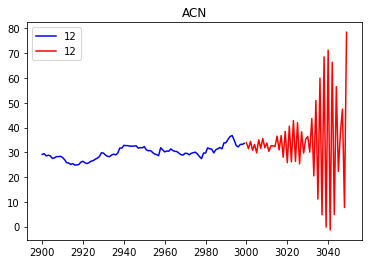

In [84]:
series_df=pd.DataFrame(series)
series_df.columns=tickers
cumulative_df=pd.concat([series_df,forecast_df], axis=0)
cumulative_df=pd.DataFrame(np.array(cumulative_df))
cumulative_df.iloc[-(100+len(forecast_df)):-len(forecast_df),12].plot(color='blue')
cumulative_df.iloc[-len(forecast_df):,12].plot(color='red')
plt.legend()
title_ticker=tickers[12]
plt.title(title_ticker)
plt.show()

In [74]:
cumulative_df=pd.DataFrame(np.array(cumulative_df))

,AAPL,GOOGL,AMZN,MSFT,JPM,V,JNJ,PG,XOM,T,...,UPS,MDT,COST,PM,AVGO,SAP,HON,NEE,TXN,MO
0,12.159949,15.444945,11.2195,21.947464,29.596682,20.26962,46.743971,44.549095,51.984688,9.442648,...,49.611696,27.636436,60.104587,40.34628,26.731489,51.870567,40.638353,10.267545,22.763519,13.03837
1,11.887666,15.144895,11.1635,21.483007,29.230317,20.226008,46.367222,43.93418,50.712839,9.452126,...,48.963136,27.384568,58.850863,40.577695,24.854051,50.742414,39.685709,10.100843,22.238281,13.053404
2,11.766848,15.120871,11.0645,21.664069,28.907066,19.700455,46.018911,43.594926,50.123445,9.155266,...,47.868249,27.338771,58.182681,40.470464,24.656039,49.873984,38.541088,10.052448,21.85714,13.113504
3,12.074652,15.295796,11.25,21.656189,29.567956,19.966675,46.402759,43.934194,50.14204,9.49318,...,48.719046,27.750919,59.549066,40.425307,24.934723,51.26997,39.885108,9.95744,21.974417,13.28882
4,12.070704,15.165165,11.016,21.238975,28.806485,19.507674,45.5711,43.20619,48.950846,9.303697,...,46.850072,26.400003,58.032535,39.747979,24.091337,48.745835,38.85862,9.87857,21.571281,13.028348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,206.980972,162.075836,167.797852,441.484192,164.018707,249.719482,212.740173,167.323181,108.375023,17.881403,...,216.333313,105.866783,531.165649,102.845284,987.606995,160.837769,209.538727,94.012833,171.124039,49.547264
46,193.672348,81.677383,104.773178,288.202728,144.23111,240.508118,139.617447,157.545044,111.195702,15.973772,...,162.687103,78.530479,595.579285,102.896919,620.038696,123.572609,239.830383,58.877869,192.136459,42.756912
47,208.204697,188.246078,177.158722,423.273834,142.672119,251.579102,214.415115,159.753845,116.11116,17.791098,...,203.469452,111.328636,544.59906,107.033669,1390.391602,166.863174,180.448975,109.671013,183.659012,53.995117
48,191.773788,58.956085,94.646942,316.408447,172.706146,241.220795,144.65329,170.882324,100.610954,16.393461,...,179.471024,73.921745,571.053894,98.422462,168.61763,120.161171,269.461914,45.028305,174.142166,37.634014
